In [1]:
import numpy as np
import os
import cv2
import h5py
import pandas as pd

from joblib import Parallel, delayed

from scipy.ndimage import correlate,convolve
from scipy.signal import medfilt, medfilt2d
from Components import local_normalize

import matplotlib.pyplot as plt

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Mapping
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
        for ii in range(len(binrep)):
            i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)		
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(bin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #print(N)
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*bin)
    return outbin

In [3]:
#Bilinear interpolation (new)
def imbilinear(im,col,x,row,y):
    #Takes bilinear interpotalion from image
    #Starts from coordinates [y,x], ends at row,col
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1 = int(np.floor(y))
    y2 = int(np.ceil(y))
    Q11 = im[y1:y1+row,x1:x1+col]
    Q21 = im[y1:y1+row,x2:x2+col]
    Q12 = im[y2:y2+row,x1:x1+col]
    Q22 = im[y2:y2+row,x2:x2+col]
    R1 = ((x2-x)/(x2-x1+1e-12))*Q11+((x-x1)/(x2-x1+1e-12))*Q21
    R2 = ((x2-x)/(x2-x1+1e-12))*Q12+((x-x1)/(x2-x1+1e-12))*Q22
    P = ((y2-y)/(y2-y1+1e-12))*R1+((y-y1)/(y2-y1+1e-12))*R2
    return P

#MRELBP
def MRELBP(im,N,R,r,w_c,w_r):
    #Takes Median Robust Extended Local Binary Pattern from image im
    #Uses N neighbours from radii R and r, R must be larger than r
    #Median filter uses kernel sizes w_c for center pixels, w_r[0] for larger radius and w_r[1]
    #for smaller radius	
    #Grayscale values are centered at their mean and scales with global standad deviation

    #Mean grayscale value and std
    muI = im.mean()
    stdI = im.std()

    #Centering and scaling with std
    I = (im-muI)/stdI

    #Median filtering
    Ic = medfilt(I,w_c)
    #Center pixels
    d = round(R+(w_r[0]-1)/2)
    Ic = Ic[d:-d,d:-d]
    #Subtracting the mean pixel value from center pixels
    Ic = Ic-Ic.mean()
    #Bining center pixels
    Chist = np.zeros((1,2))
    Chist[0,0] = np.sum(Ic>=0)
    Chist[0,1] = np.sum(Ic<0)
    # --------------- #
    #Chist[0,0] = np.sum(Ic>=-1e-06)
    #Chist[0,1] = np.sum(Ic<-1e-06)
    # --------------- #
    

    #Median filtered images for large and small radius
    IL = medfilt(I,w_r[0])
    #d1 = round((w_r[0]-1)/2)
    #IL = IL[d1:-d1,d1:-d1]
    IS = medfilt2d(I,w_r[1])
    #d2 = round((w_r[1]-1)/2)
    #IS = IS[d2:-d2,d2:-d2]

    #Neighbours
    pi = np.pi
    #Empty arrays for the neighbours
    row,col = np.shape(Ic)
    NL = np.zeros((row,col,N))
    NS = np.zeros((row,col,N))
    #print("Size (Ic): " + str(row) + ", " + str(col))
    for k in range(N):
        #Angle to the neighbour
        theta = 0+k*(-1*2*pi/N)
        #Large neighbourhood
        x = d+R*np.cos(theta)
        y = d+R*np.sin(theta)
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IL[y:y+row,x:x+col]
        else:
            P = imbilinear(IL,col,x,row,y)
        NL[:,:,k] = P
        #Small neighbourhood
        #x = r+r*np.cos(theta)
        #y = r+r*np.sin(theta)
        # --------------- #
        x = d+r*np.cos(theta)
        y = d+r*np.sin(theta)
        # --------------- #
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IS[y:y+row,x:x+col]
        else:
            P = imbilinear(IS,col,x,row,y)
        NS[:,:,k] = P
    #Thresholding

    #Thresholding radial neighbourhood
    NR = NL-NS

    #Subtraction of means
    #Large neighbourhood
    NLmu = NL.mean(axis=2)		
    #Small neighbouhood
    NSmu = NS.mean(axis=2)

    for k in range(N):
        NL[:,:,k] = NL[:,:,k]-NLmu
        NS[:,:,k] = NS[:,:,k]-NSmu	

    #Converting to binary images and taking the lbp values

    #Initialization of arrays
    lbpIL = np.zeros((row,col))
    lbpIS = np.zeros((row,col))
    lbpIR = np.zeros((row,col))

    for k in range(N):
        lbpIL = lbpIL+(NL[:,:,k]>=0)*2**k # NOTE ACCURACY FOR THRESHOLDING!!!
        lbpIS = lbpIS+(NS[:,:,k]>=0)*2**k
        lbpIR = lbpIR+(NR[:,:,k]>=0)*2**k
        # --------------- #
        #lbpIL = lbpIL+(NL[:,:,k]>=-1e-06)*2**k # NOTE ACCURACY FOR THRESHOLDING!!!
        #lbpIS = lbpIS+(NS[:,:,k]>=-1e-06)*2**k
        #lbpIR = lbpIR+(NR[:,:,k]>=-1e-06)*2**k
        # --------------- #

    #Binning
    Lhist = np.zeros((1,2**N))
    Shist = np.zeros((1,2**N))
    Rhist = np.zeros((1,2**N))
    for k in range(2**N):
        Lhist[0,k] = np.sum(lbpIL==k)
        Shist[0,k] = np.sum(lbpIS==k)
        Rhist[0,k] = np.sum(lbpIR==k)

    #Chist = 1/np.linalg.norm(Chist)*Chist
    #Lhist = 1/np.linalg.norm(Lhist)*Lhist
    #Shist = 1/np.linalg.norm(Shist)*Shist
    #Rhist = 1/np.linalg.norm(Rhist)*Rhist
    #Mapping
    mapping = getmapping(N)
    Lhist = maplbp(Lhist,mapping)
    Shist = maplbp(Shist,mapping)
    Rhist = maplbp(Rhist,mapping)
    hist = np.concatenate((Chist,Lhist,Shist,Rhist),1)
    
    return hist, lbpIL, lbpIS, lbpIR

In [4]:
def weight_matrix_bilin(r,theta,val = -1):
    #Center of the matrix
    x = r+1
    y = r+1
    
    #Matrix
    s = int(2*(r+1)+1)
    kernel = np.zeros((s,s))
    
    #Accurate location
    _y = y+np.sin(theta)*r
    _x = x+np.cos(theta)*r
    #Rounded locations
    x1 = np.floor(_x)
    x2 = np.ceil(_x)
    y1 = np.floor(_y)
    y2 = np.ceil(_y)
    
    #Interpolation weights
    wx2 = (_x-x1)
    if wx2 == 0:
        wx2 = 1
    wx1 = (x2-_x)
    if wx1 == 0:
        wx1 = 1
    wy2 = (_y-y1)
    if wy2 == 0:
        wy2 = 1
    wy1 = (y2-_y)
    if wy1 == 0:
        wy1 = 1
    
    w11 = wx1*wy1
    w12 = wx2*wy1
    w21 = wx1*wy2
    w22 = wx2*wy2


    kernel[int(y1),int(x1)] = w11
    kernel[int(y1),int(x2)] = w12
    kernel[int(y2),int(x1)] = w21
    kernel[int(y2),int(x2)] = w22
    
    #Set center value
    kernel[x,y] += val
    
    return kernel

def Conv_MRELBP(image,N,R,r,wR,wr,wc):
    #Whiten the image
    imu = image.mean()
    istd = image.std()
    im = (image-imu)/istd
    #Get image dimensions
    h,w = im.shape[:2]
    #Make kernels
    kR = []
    kr = []
    dtheta = np.pi*2/N
    for k in range(0,N):
        _kernel = weight_matrix_bilin(R,-k*dtheta,val=0)
        kR.append(_kernel)
        
        _kernel = weight_matrix_bilin(r,-k*dtheta,val=0)
        kr.append(_kernel)
        
    #Make median filtered images
    imc = medfilt2d(im.copy(),wc)
    imR = medfilt2d(im.copy(),wR)
    imr = medfilt2d(im.copy(),wr)
        
    #Get LBP images
    neighbR = np.zeros((h,w,N))
    neighbr = np.zeros((h,w,N))
    for k in range(N):
        _neighb = correlate(imR,kR[k])
        neighbR[:,:,k] = _neighb
        _neighb = correlate(imr,kr[k])
        neighbr[:,:,k] = _neighb
    
    
    #Crop valid convolution region
    d = R+wR//2
    h -=2*d
    w -=2*d
    
    
    neighbR = neighbR[d:-d,d:-d,:]
    neighbr = neighbr[d:-d,d:-d,:]
    imc = imc[d:-d,d:-d]
    
    #Subtraction
    _muR = neighbR.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            muR = np.concatenate((muR,_muR),2)
        except NameError:
            muR = _muR
            
    _mur = neighbr.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            mur = np.concatenate((mur,_mur),2)
        except NameError:
            mur = _mur
            
    diffc = (imc-imc.mean())>=0
    diffR = (neighbR-muR)>=0
    diffr = (neighbr-mur)>=0
    diffR_r = (neighbR-neighbr)>=0
    
    #Compute lbp images
    lbpc = diffc
    lbpR = np.zeros((h,w))
    lbpr = np.zeros((h,w))
    lbpR_r = np.zeros((h,w))
    for k in range(N):
        lbpR += diffR[:,:,k]*(2**k)
        lbpr += diffr[:,:,k]*(2**k)
        lbpR_r += diffR_r[:,:,k]*(2**k)
    #Get LBP histograms
    histc = np.zeros((1,2))
    histR = np.zeros((1,2**N))
    histr = np.zeros((1,2**N))
    histR_r = np.zeros((1,2**N))
    
    histc[0,0] = (lbpc==1).astype(np.float32).sum()
    histc[0,1] = (lbpc==0).astype(np.float32).sum()
    
    for k in range(2**N):
        histR[0,k] = (lbpR==k).astype(np.float32).sum()
        histr[0,k] = (lbpr==k).astype(np.float32).sum()
        histR_r[0,k] = (lbpR_r==k).astype(np.float32).sum()
    
    
    #Mapping
    mapping = getmapping(N)
    histR = maplbp(histR,mapping)
    histr = maplbp(histr,mapping)
    histR_r = maplbp(histR_r,mapping)
    print(len(histR[0]))
    #Append histograms
    hist = np.concatenate((histc,histR,histr,histR_r),1)
    
    return hist, lbpR, lbpr, lbpR_r

Showing test images


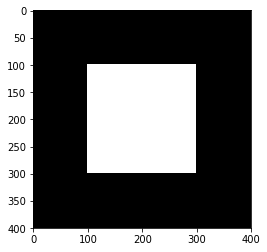

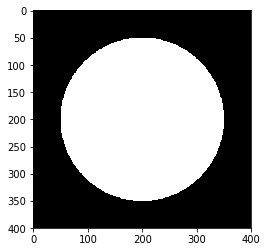

Showing interpolated images


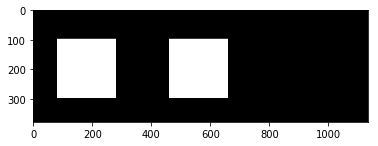

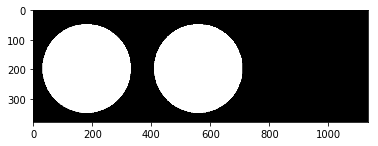

Differences: 1.4278882504837558e-10 | 2.5224002865206864e-10


In [5]:
#Interpolation tests

#Image generation
im1 = np.zeros((400,400))
im1[100:300,100:300] = 255

im2 = np.zeros((400,400))
for ky in range(400):
    for kx in range(400):
        val = (ky-200)**2+(kx-200)**2
        if val < 150**2:
            im2[ky,kx] = 255

print("Showing test images")
plt.imshow(im1,cmap='gray')
plt.show()
plt.imshow(im2,cmap='gray')
plt.show()

#Interpolation, R = 11, theta = -45 degrees
R = 11
theta = -1*np.pi/4

x = R+np.cos(theta)*R
y = R+np.sin(theta)*R

col = 400-2*R
row = 400-2*R

#Old method
intp1 = imbilinear(im1,col,x,row,y)
intp2 = imbilinear(im2,col,x,row,y)

#Convolution
kernel = weight_matrix_bilin(R,theta,val = 0)
cintp1 = correlate(im1,kernel)[R:-R,R:-R]
cintp2 = correlate(im2,kernel)[R:-R,R:-R]

I1 = np.concatenate((intp1,cintp1,(intp1-cintp1)**2),1)
I2 = np.concatenate((intp2,cintp2,(intp2-cintp2)**2),1)

print("Showing interpolated images")
plt.imshow(I1,cmap='gray')
plt.show()
plt.imshow(I2,cmap='gray')
plt.show()

print("Differences: {0} | {1}".format(np.abs(intp1-cintp1).sum()/(row*col),np.abs(intp2-cintp2).sum()/(row*col)))

Showing test images


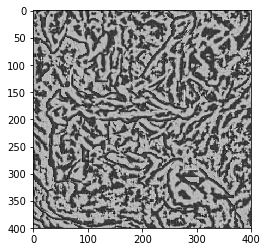

Showing interpolated images


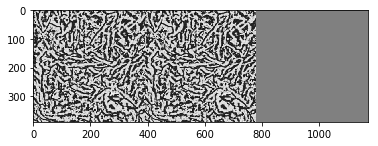

Differences: 1.5578282144206807e-12


In [6]:
#Interpolation tests 2

#Image loading
h5 = h5py.File('../cartvoi_surf_new/13_R3L__surf.h5','r')
im1 = h5['sum'][:]
h5.close()

im1 = local_normalize(im1, 23, 5, 5, 1)

print("Showing test images")
plt.imshow(im1,cmap='gray')
plt.show()

#Interpolation, R = 5, theta = -135 degrees
R = 5
theta = -3*np.pi/4

x = R+np.cos(theta)*R
y = R+np.sin(theta)*R

col = 400-2*R
row = 400-2*R

#Old method
intp1 = imbilinear(im1,col,x,row,y)

#Convolution
kernel = weight_matrix_bilin(R,theta,val = 0)
cintp1 = correlate(im1,kernel)[R:-R,R:-R]

I1 = np.concatenate((intp1,cintp1,(intp1-cintp1)**2),1)

print("Showing interpolated images")
plt.imshow(I1,cmap='gray')
plt.show()

print("Differences: {0}".format(np.abs(intp1-cintp1).sum()/(row*col)))

10
10


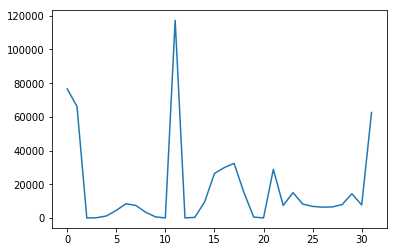

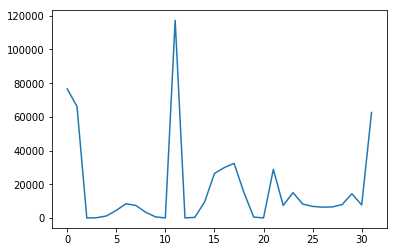

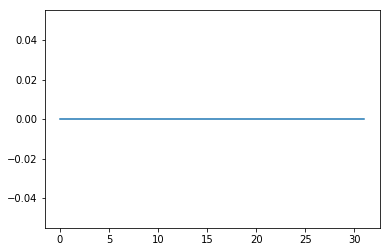

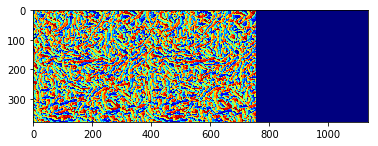

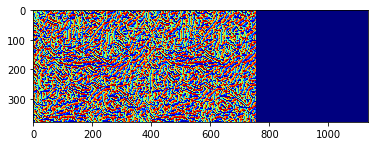

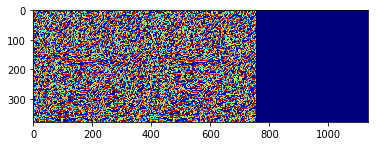

(378, 378)


In [8]:
#LBP test

#Image loading
h5 = h5py.File('../cartvoi_surf_new/13_R3L__surf.h5','r')
im1 = h5['sum'][:]
h5.close()
im1 = local_normalize(im1, 23, 5, 5, 1)

#LBPs
stuff1 = MRELBP(im1,8,9,3,5,(5,5))
stuff2 = Conv_MRELBP(im1,8,9,3,5,5,5)

#Compute errors

#Histogram
hist1 = stuff1[0][0]
plt.plot(hist1)
plt.show()

hist2 = stuff2[0][0]
plt.plot(hist2)
plt.show()

err1 = (stuff1[0][0]-stuff2[0][0])**2
plt.plot(err1)
plt.show()

#Large LBP
IR = np.concatenate((stuff1[1],stuff2[1],(stuff1[1]-stuff2[1])**2),1)

plt.imshow(IR,cmap='jet')
plt.show()

Ir = np.concatenate((stuff1[2],stuff2[2],(stuff1[2]-stuff2[2])**2),1)
plt.imshow(Ir,cmap='jet')
plt.show()

IR_r = np.concatenate((stuff1[3],stuff2[3],(stuff1[3]-stuff2[3])**2),1)
plt.imshow(IR_r,cmap='jet')
plt.show()

print(stuff1[1].shape)